# Assistente de Concessionária — Indicadores & Métricas

Neste _notebook_, serão apresentados alguns indicadores e algumas métricas de desempenho do _chatbot_.

## 1 - Preparar o conjunto de dados

É necessário avaliar o conjunto de dados para prepará-lo para a análise; verificar se não há erros e/ou inconsistências.

### 1.1 - Carregar conjunto de dados

Começamos carregando o dito conjunto de dados.

In [1]:
import pandas as pd

In [2]:
def carregar_dataset() -> pd.DataFrame:
    return pd.read_csv('mensagens.csv', sep=';', index_col=False)

df_mensagens = carregar_dataset()

print(f'{len(df_mensagens)} mensagens')

199 mensagens


In [3]:
df_mensagens.head()

,mensagem,data,horario,intencoes,entidades
0,dinheiro,2021-05-20,21:23,NaN,NaN
1,carro,2021-05-20,21:23,#recomendar-modelo,NaN
2,fusion,2021-05-20,21:24,NaN,@modelo-carro:Ford Fusion Hybrid 2021
3,ford,2021-05-20,21:24,NaN,NaN
4,aff,2021-05-20,21:24,NaN,NaN


### 1.2 - Checar integridade dos campos de texto

Checar se algum dos campos de texto possui um ou mais elementos vazios.

In [4]:
def checar_serie_possui_str_vazia(serie: pd.Series) -> bool:
    return serie.apply(lambda x: not x).any()

colunas_texto = ['mensagem', 'data', 'horario']

for col in colunas_texto:
    print(f'{col}:', checar_serie_possui_str_vazia(df_mensagens[col]))

mensagem: False
data: False
horario: False


### 1.3 - Converter tipos de dados

#### 1.3.1 - Datas e horários em `datetime`

Converter datas e horários para o tipo `datetime`.

In [5]:
from datetime import datetime

def obter_datahorario_linha(linha: pd.Series) -> datetime:
    return datetime.fromisoformat(' '.join(linha.values))

def obter_serie_datahorario(tabela: pd.DataFrame) -> pd.Series:
    return tabela.apply(obter_datahorario_linha, axis=1)

colunas_datahora_mensagens = ['data', 'horario']

df_mensagens['data_horario'] = obter_serie_datahorario(df_mensagens[colunas_datahora_mensagens])
df_mensagens.drop(colunas_datahora_mensagens, axis=1, inplace=True)

for col in colunas_datahora_mensagens:
    colunas_texto.remove(col)

for col in ['data', 'horario']:
    colunas_datahora_mensagens.remove(col)

colunas_datahora_mensagens.append('data_horario')

df_mensagens[colunas_datahora_mensagens].head()

,data_horario
0,2021-05-20 21:23:00
1,2021-05-20 21:23:00
2,2021-05-20 21:24:00
3,2021-05-20 21:24:00
4,2021-05-20 21:24:00


#### 1.3.2 - Intenções e entidades em `List[str]`

Converter intenções e entidades em listas.

In [6]:
df_mensagens.fillna('', inplace=True)

df_mensagens.head()

,mensagem,intencoes,entidades,data_horario
0,dinheiro,,,2021-05-20 21:23:00
1,carro,#recomendar-modelo,,2021-05-20 21:23:00
2,fusion,,@modelo-carro:Ford Fusion Hybrid 2021,2021-05-20 21:24:00
3,ford,,,2021-05-20 21:24:00
4,aff,,,2021-05-20 21:24:00


In [7]:
def obter_serie_lista_textos(serie: pd.Series) -> pd.Series:
    return serie.str.split(',')

colunas_listas = ['intencoes', 'entidades']

for col in colunas_listas:
    df_mensagens[col] = obter_serie_lista_textos(df_mensagens[col])

df_mensagens[colunas_listas].head()

,intencoes,entidades
0,[],[]
1,[#recomendar-modelo],[]
2,[],[@modelo-carro:Ford Fusion Hybrid 2021]
3,[],[]
4,[],[]


Quais são os tamanhos mínimo e máximo dessas listas?

In [8]:
from typing import Tuple

def obter_serie_tamanho_lista(serie: pd.Series) -> pd.Series:
    return serie.apply(len)

def obter_minmax_serie_lista(serie: pd.Series) -> Tuple[int, int]:
    tamanhos = obter_serie_tamanho_lista(serie)
    return (tamanhos.min(), tamanhos.max())

for col in colunas_listas:
    print(f'{col}:', obter_minmax_serie_lista(df_mensagens[col]))

intencoes: (1, 1)
entidades: (1, 3)


Limpar listas, removendo elementos vazios.

In [9]:
def filtrar_apenas_elementos_nao_vazios(x):
    return [e for e in x if bool(e)]

def remover_elementos_vazios_listas_serie(serie: pd.Series) -> pd.Series:
    return serie.apply(filtrar_apenas_elementos_nao_vazios)

for col in colunas_listas:
    df_mensagens[col] = remover_elementos_vazios_listas_serie(df_mensagens[col])
    print(f'{col}:', obter_minmax_serie_lista(df_mensagens[col]))

intencoes: (0, 1)
entidades: (0, 3)


#### 1.3.3 - Entidades em `List[Tuple[str, str]]`

Quebrar as entidades em duplas entidade–valor.

In [10]:
from typing import Iterable, List

def obter_tupla_entidade_valor_de_termo(termo: str) -> Tuple[str, str]:
    # `maxsplit == 1`, porque horários h, min e s são separados por ':'.
    return tuple(filtrar_apenas_elementos_nao_vazios(termo.split(':', maxsplit=1)))

def obter_lista_tuplas_entidade_valor(termos: Iterable[str]) -> List[Tuple[str, str]]:
    return [obter_tupla_entidade_valor_de_termo(termo) for termo in termos]

def obter_lista_tuplas_entidade_valor_nao_vazias(termos: Iterable[str]) -> List[Tuple[str, str]]:
    lista_tuplas = obter_lista_tuplas_entidade_valor(termos)
    return filtrar_apenas_elementos_nao_vazios(lista_tuplas)

def obter_serie_lista_tuplas_entidade_valor_nao_vazias(serie: pd.Series) -> pd.Series:
    return serie.apply(obter_lista_tuplas_entidade_valor_nao_vazias)

df_mensagens['entidades'] = obter_serie_lista_tuplas_entidade_valor_nao_vazias(df_mensagens['entidades'])

df_mensagens['entidades'].head()

0                                            []
1                                            []
2    [(@modelo-carro, Ford Fusion Hybrid 2021)]
3                                            []
4                                            []
Name: entidades, dtype: object

Isso resultou em listas vazias ou apenas com tuplas de 2 elementos?

In [11]:
import numpy as np
from typing import Any

def obter_tamanhos_tuplas(tuplas: Iterable[Tuple[Any, ...]]) -> List[int]:
    return [len(tp) for tp in tuplas]

def checar_tamanhos_tuplas_em_lista_igual_a(tuplas: Iterable[Tuple[Any, ...]], tamanho: int) -> bool:
    return (np.array(obter_tamanhos_tuplas(tuplas)) == tamanho).all()

filtro_listas_entidades_vazias = obter_serie_tamanho_lista(df_mensagens['entidades']) == 0
filtro_listas_entidades_tuplas_2_elementos = df_mensagens['entidades'].apply(lambda x: checar_tamanhos_tuplas_em_lista_igual_a(x, 2))
filtro_listas_entidades_validas = filtro_listas_entidades_vazias | filtro_listas_entidades_tuplas_2_elementos

filtro_listas_entidades_validas.all()

True

## 2 - Indicadores

Extrair os dados dos indicadores e apresentá-los em gráficos.

### 2.1 - Mensagens por dia

Quantas mensagens foram enviadas pelos clientes dentro do período analisado?

#### 2.1.1 - Período analisado

Obter a data mais antiga e a mais recente dentre as mensagens.

In [12]:
data_mais_antiga, data_mais_recente = (
    df_mensagens['data_horario'].min().date(),
    df_mensagens['data_horario'].max().date()
)

print('Mais antiga.:', data_mais_antiga)
print('Mais recente:', data_mais_recente)

Mais antiga.: 2021-05-20
Mais recente: 2021-05-23


#### 2.1.2 - Contagem

Contar o número de mensagens por dia.

In [13]:
from datetime import timedelta

numero_dias_intervalo_datas = (data_mais_recente - data_mais_antiga).days + 1
intervalo_datas = [data_mais_antiga + timedelta(days=d) for d in range(numero_dias_intervalo_datas)]
intervalo_dias_seguintes = [data + timedelta(days=1) for data in intervalo_datas]

print(f'Intervalo de {numero_dias_intervalo_datas} dias')

Intervalo de 4 dias


In [14]:
serie_datas_mensagens = df_mensagens['data_horario'].apply(datetime.date)

mensagens_por_dia = {
    dia: ((serie_datas_mensagens >= dia) & (serie_datas_mensagens < dia_seguinte)).sum()
    for (dia, dia_seguinte) in zip(intervalo_datas, intervalo_dias_seguintes)
}

#### 2.1.3 - Gráfico

Apresentar o gráfico de mensagens por dia, ao longo do tempo.

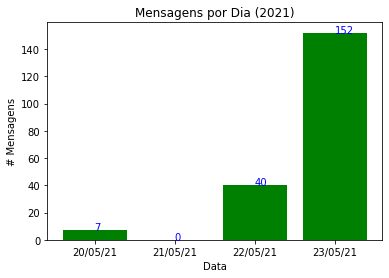

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

x_mensagens_por_dia = [f'{data:%d/%m/%y}' for data in mensagens_por_dia.keys()]
y_mensagens_por_dia = mensagens_por_dia.values()

plt.bar(x_mensagens_por_dia, y_mensagens_por_dia, color='green')
plt.title('Mensagens por Dia (2021)')
plt.xlabel('Data')
plt.ylabel('# Mensagens')

for (x, y) in zip(x_mensagens_por_dia, y_mensagens_por_dia):
    plt.annotate(y, (x, y), color='blue')

plt.show()

### 2.2 - Intenções mais declaradas

Quais intenções são as mais declaradas pelos clientes que conversam com o _chatbot_?

#### 2.2.1 - Contagem

Conta-se o número de ocorrências de cada intenção declarada em conversas dentro do período.

In [16]:
from collections import Counter

contagem_intencoes = Counter(intencao for lista in df_mensagens['intencoes'] for intencao in lista)

#### 2.2.2 - Gráfico

Apresentar um comparativo das intenções num gráfico de barras.

In [17]:
contagem_intencoes = dict(sorted(contagem_intencoes.items(), key=lambda x: x[1]))

# #confirmacao e #declinacao são intenções gerais.
# Vamos desconsiderá-las nesta análise.
for k in ['#confirmacao', '#declinacao']:
    contagem_intencoes.pop(k)

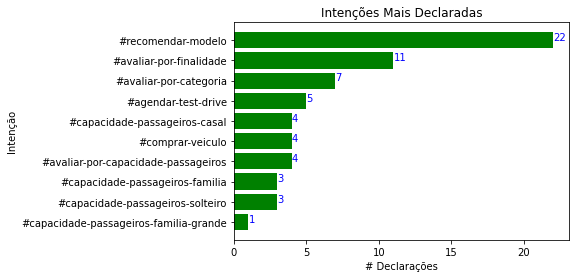

In [18]:
plt.barh(
    list(contagem_intencoes.keys()),
    list(contagem_intencoes.values()),
    color='green'
)
plt.title('Intenções Mais Declaradas')
plt.xlabel('# Declarações')
plt.ylabel('Intenção')

for (k, v) in contagem_intencoes.items():
    plt.annotate(v, (v, k), color='blue')

plt.show()

Observa-se que as cinco intenções mais declaradas pelos clientes são, da mais para a menos declarada:

1. `#recomendar-modelo`: 22;
2. `#avaliar-por-finalidade`: 11;
3. `#avaliar-por-categoria`: 7;
4. `#agendar-test-drive`: 5;
5. `#capacidade-passageiros-casal`: 4.

É estranho que `#capacidade-passageiros-casal` esteja entre as intenções mais declaradas, ainda mais considerando que essa é complementar a `#avaliar-por-capacidade-passageiros`. Por outro lado, observa-se também que `avaliar-por-capacidade-passageiros` foi declarada tantas vezes quanto `#capacidade-passageiros-casal`.

Vamos ver como essas cinco se comparam com o todo, ainda sem considerar `#confirmacao` e `#declinacao`.

In [19]:
contagem_intencoes_com_outros = dict(sorted(list(contagem_intencoes.items())[-5:], key=lambda x: -x[1]))
contagem_intencoes_com_outros['Outras'] = sum(list(contagem_intencoes.values())[:-5])

contagem_total_intencoes = sum(contagem_intencoes_com_outros.values())
contagem_intencoes_com_outros = {k: v/contagem_total_intencoes for (k,v) in contagem_intencoes_com_outros.items()}

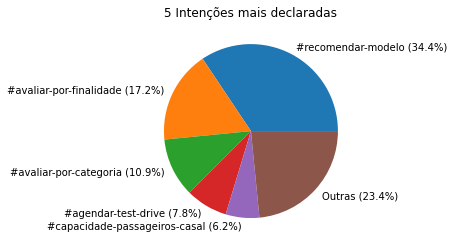

In [20]:
plt.pie(
    contagem_intencoes_com_outros.values(),
    labels=[f'{k} ({v:.1%})' for (k,v) in contagem_intencoes_com_outros.items()]
)
plt.title('5 Intenções mais declaradas')
plt.show()